## A demo notebook for callback in XGBoost CV function

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
#no need in train_test_split for CV
#from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
#reg expression to get individual scores from a string output
import re

### Dataset, target, featureset and transforming to DMatrix

In [2]:
dataset = pd.read_csv('/home/kate/Research/YearBuilt/Data/dwelling_basedata_v4.csv', error_bad_lines=False, index_col=False)

In [3]:
target='hasclaim_water'
featureset=['yearbuilt', 'cova_deductible', 'sqft','water_risk_3_blk']

No need to split into train/test(valid) sets or folds

In [4]:
X = dataset[featureset]
y = dataset[target]
d_train = xgb.DMatrix(X, y)

### XGBoost parameters
The dataset is highly imbalanced. Usually a custom gini evaluation function is used in insurance datasets but fo simplicity I use a standard AUC function.

In [5]:
#parameters
params={'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 'seed': 42,
 'colsample_bylevel': 0.6,
 'colsample_bytree': 0.8,
 'scale_pos_weight': 0.3,
 'eta': 0.018,       
 'subsample': 0.6,
 }
nfold = 10
num_boost_round = 5000
early_stopping_rounds = 100

### Callback function

In [6]:
def cv_misc_callback(oof_train_scores:list, oof_valid_scores:list, best_models:list,  maximize=True):
    """
    It's called inside XGB CV to catch individual folds scores and models
    """    
    state = {}
    def init(env):
        if maximize:
            state['best_score'] = -np.inf
        else:
            state['best_score'] = np.inf 
#--------------------------------------------------------------------------------            
    def callback(env):
        #init env if empty
        if not state:
            init(env)
        best_score = state['best_score']
        score = env.evaluation_result_list[-1][1]
        #extract best model if a current score is better then previous
        if (maximize and score > best_score) or (not maximize and score < best_score):
            for i, cvpack in enumerate(env.cvfolds): 
                best_models[i]=cvpack.bst
            state['best_score'] = score    
        #all iterations individual folds scores
        folds_train_scores = []
        folds_valid_scores = []
        for i, cvpack in enumerate(env.cvfolds):            
            scores = cvpack.eval(iteration=0,feval=None)
            #print(scores)
            scores_l = re.split(': |\t',scores)
            train_score=scores_l[1].rpartition(':')[2]
            valid_score=scores_l[2].rpartition(':')[2]
            folds_train_scores.append(train_score)
            folds_valid_scores.append(valid_score)
        oof_train_scores.append(folds_train_scores)
        oof_valid_scores.append(folds_valid_scores)
#--------------------------------------------------------------------------------        
    callback.before_iteration = False
    return callback

### CV with callback functions

In [7]:
#OUT parameters from custom callback function: 
#train and valid scores from all folds
oof_train_scores = []
oof_valid_scores = []
#Best Model
best_models=[None]*nfold
    
cv_results=xgb.cv(params, 
                  d_train, 
                  num_boost_round=num_boost_round,
                  nfold=nfold, 
                  stratified=True, 
                  shuffle=True,
                  early_stopping_rounds=early_stopping_rounds, 
                  seed=42,
                   callbacks=[cv_misc_callback(oof_train_scores, oof_valid_scores,best_models,True), xgb.callback.print_evaluation(period=10)] 
                     )

[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[10]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[20]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[30]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[40]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[50]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[60]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[70]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[80]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[90]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[100]	train-auc:0.53375+0.04134	test-auc:0.52980+0.03690
[110]	train-auc:0.61510+0.01833	test-auc:0.60849+0.01420
[120]	train-auc:0.62726+0.00981	test-auc:0.62485+0.02029
[130]	train-auc:0.63985+0.00343	test-auc:0.63530+0.01468
[140]	train-auc:0.64470+0.00567	test-auc:0.63992+0.01414
[150]	train-auc:0.64840+0.00680	test-auc:0.64468+0.01777
[160]	train-auc:0.65576+0.00398	test-auc:0.65168+0.01855
[170]	train-auc:0.65938+0.00380	test-auc:0

### CV Result

In [8]:
cv_results.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
691,0.729942,0.001573,0.687806,0.015197
692,0.729998,0.001572,0.687810,0.015194
693,0.730056,0.001574,0.687823,0.015194
694,0.730084,0.001564,0.687826,0.015202
695,0.730137,0.001560,0.687837,0.015183


### Custom CV Result from a callback function with individual folds metrics
Let's convert lists to pandas dataframe and calculate STD and SEM

In [9]:
#scores to dataframe
df_oof_train_scores = pd.DataFrame.from_records(oof_train_scores).apply(pd.to_numeric)
df_oof_valid_scores = pd.DataFrame.from_records(oof_valid_scores).apply(pd.to_numeric)

In [10]:
#only folds scores columns names
columns = df_oof_train_scores.columns.tolist()

In [11]:
#mean and std, sem 
df_oof_train_scores['std'] = df_oof_train_scores[columns].std(axis=1)
df_oof_valid_scores['std'] = df_oof_valid_scores[columns].std(axis=1)
df_oof_train_scores['sem'] = df_oof_train_scores[columns].sem(axis=1)
df_oof_valid_scores['sem'] = df_oof_valid_scores[columns].sem(axis=1)    
df_oof_train_scores['mean'] = df_oof_train_scores[columns].mean(axis=1)
df_oof_valid_scores['mean'] = df_oof_valid_scores[columns].mean(axis=1)

In [12]:
df_oof_train_scores.tail()

,0,1,2,3,4,5,6,7,8,9,std,sem,mean
791,0.735064,0.735104,0.736658,0.735220,0.734851,0.734872,0.739483,0.736426,0.735215,0.735818,0.001418,0.000449,0.735871
792,0.735095,0.735177,0.736683,0.735259,0.734865,0.734899,0.739491,0.736517,0.735308,0.735933,0.001410,0.000446,0.735923
793,0.735140,0.735224,0.736726,0.735302,0.734933,0.734914,0.739524,0.736520,0.735352,0.735974,0.001405,0.000444,0.735961
794,0.735178,0.735296,0.736740,0.735449,0.734973,0.734960,0.739541,0.736532,0.735376,0.736010,0.001389,0.000439,0.736006
795,0.735239,0.735383,0.736768,0.735530,0.734995,0.735020,0.739602,0.736540,0.735416,0.736025,0.001387,0.000439,0.736052


In [13]:
df_oof_valid_scores.tail()

,0,1,2,3,4,5,6,7,8,9,std,sem,mean
791,0.705811,0.693888,0.674917,0.679050,0.714809,0.694630,0.657618,0.688595,0.683779,0.682329,0.016115,0.005096,0.687543
792,0.705817,0.693903,0.674868,0.679003,0.714863,0.694604,0.657607,0.688551,0.683657,0.682485,0.016132,0.005101,0.687536
793,0.705779,0.693944,0.674881,0.678924,0.714802,0.694577,0.657672,0.688561,0.683647,0.682396,0.016110,0.005094,0.687518
794,0.705714,0.693914,0.674875,0.678910,0.714855,0.694593,0.657623,0.688544,0.683658,0.682407,0.016121,0.005098,0.687509
795,0.705704,0.693926,0.674860,0.678882,0.714846,0.694548,0.657598,0.688539,0.683622,0.682378,0.016127,0.005100,0.687490


There are 100 (early_stopping_rounds) more results in the custom result then in in the standard output (cv_results)

In [14]:
data=pd.concat([df_oof_train_scores[['mean','sem','std']],df_oof_valid_scores[['mean','sem','std']]],axis=1)
data.columns=['train-auc-mean','train-auc-sem','train-auc-std','valid-auc-mean','valid-auc-sem','valid-auc-std']
data.tail()

,train-auc-mean,train-auc-sem,train-auc-std,valid-auc-mean,valid-auc-sem,valid-auc-std
791,0.735871,0.000449,0.001418,0.687543,0.005096,0.016115
792,0.735923,0.000446,0.001410,0.687536,0.005101,0.016132
793,0.735961,0.000444,0.001405,0.687518,0.005094,0.016110
794,0.736006,0.000439,0.001389,0.687509,0.005098,0.016121
795,0.736052,0.000439,0.001387,0.687490,0.005100,0.016127


Let's select the best score from our custom results

In [15]:
#max or mean depending on the score
BestTestScore=data['valid-auc-mean'].max()
#even if there are more then 1 rows with the same max valid-auc-mean use only first: head(1)
BestModelResult=data[data['valid-auc-mean']==BestTestScore].head(1).copy()
BestModelResult

,train-auc-mean,train-auc-sem,train-auc-std,valid-auc-mean,valid-auc-sem,valid-auc-std
695,0.730137,0.00052,0.001645,0.687837,0.005061,0.016004


Now compare means and std between standard output (the last row) and BestModelResult extracted from custom results: train and valid means are the same, best iteration is the same, but std are different!

### Visualization of the custom output

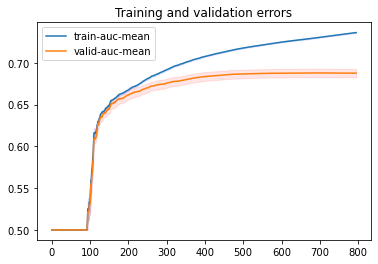

In [16]:
ax=data[['train-auc-mean','valid-auc-mean']].plot(title='Training and validation errors')
ax.fill_between(data.index.values, (data['train-auc-mean'].values-data['train-auc-sem'].values), (data['train-auc-mean'].values + data['train-auc-sem'].values), color='b', alpha=.1)
ax.fill_between(data.index.values, (data['valid-auc-mean'].values-data['valid-auc-sem'].values), (data['valid-auc-mean'].values + data['valid-auc-sem'].values), color='r', alpha=.1)

Well, it looks like overfitting

### Feature importance from CV best models

In [17]:
#there are as many models as folds. I calculate feature importance for all of them and then mean, std and sem
oof_fi_weight_best = {}
oof_fi_gain_best = {}
oof_fi_cover_best = {}
for i in range(0,nfold):
    oof_fi_weight_best[i]=best_models[i].get_score(importance_type='weight')
    oof_fi_gain_best[i]= best_models[i].get_score(importance_type='gain')
    oof_fi_cover_best[i]= best_models[i].get_score(importance_type='cover')
    
#converting to dataframe
df_oof_fi_weight_best = pd.DataFrame(oof_fi_weight_best).apply(pd.to_numeric)
df_oof_fi_gain_best = pd.DataFrame(oof_fi_gain_best).apply(pd.to_numeric)
df_oof_fi_cover_best = pd.DataFrame(oof_fi_cover_best).apply(pd.to_numeric)
    
    
#mean and std, sem 
df_oof_fi_weight_best['std'] = df_oof_fi_weight_best[columns].std(axis=1)
df_oof_fi_gain_best['std'] = df_oof_fi_gain_best[columns].std(axis=1)
df_oof_fi_cover_best['std'] = df_oof_fi_cover_best[columns].std(axis=1)
    
df_oof_fi_weight_best['sem'] = df_oof_fi_weight_best[columns].sem(axis=1)
df_oof_fi_gain_best['sem'] = df_oof_fi_gain_best[columns].sem(axis=1)
df_oof_fi_cover_best['sem'] = df_oof_fi_cover_best[columns].sem(axis=1)
    
df_oof_fi_weight_best['mean'] = df_oof_fi_weight_best[columns].mean(axis=1)
df_oof_fi_gain_best['mean'] = df_oof_fi_gain_best[columns].mean(axis=1)
df_oof_fi_cover_best['mean'] = df_oof_fi_cover_best[columns].mean(axis=1)
    
    
#feature codes from index to column
df_oof_fi_weight_best.reset_index(level=0, inplace=True)
df_oof_fi_weight_best.columns=['feature'] + columns + ['std','sem','mean']
df_oof_fi_gain_best.reset_index(level=0, inplace=True)
df_oof_fi_gain_best.columns=['feature'] + columns + ['std','sem','mean']
df_oof_fi_cover_best.reset_index(level=0, inplace=True)
df_oof_fi_cover_best.columns=['feature'] + columns + ['std','sem','mean']

In [18]:
df_oof_fi_weight_best.sort_values('mean',ascending=False,inplace=True)
df_oof_fi_gain_best.sort_values('mean',ascending=False,inplace=True)
df_oof_fi_cover_best.sort_values('mean',ascending=False,inplace=True)

<ipython-input-19-01f3680bc766>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_oof_fi_gain_best['feature'].values,rotation=90)
<ipython-input-19-01f3680bc766>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_oof_fi_weight_best['feature'].values,rotation=90)
<ipython-input-19-01f3680bc766>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_oof_fi_cover_best['feature'].values,rotation=90)


[Text(0, 0, 'cova_deductible'),
 Text(1, 0, 'yearbuilt'),
 Text(2, 0, 'water_risk_3_blk'),
 Text(3, 0, 'sqft')]

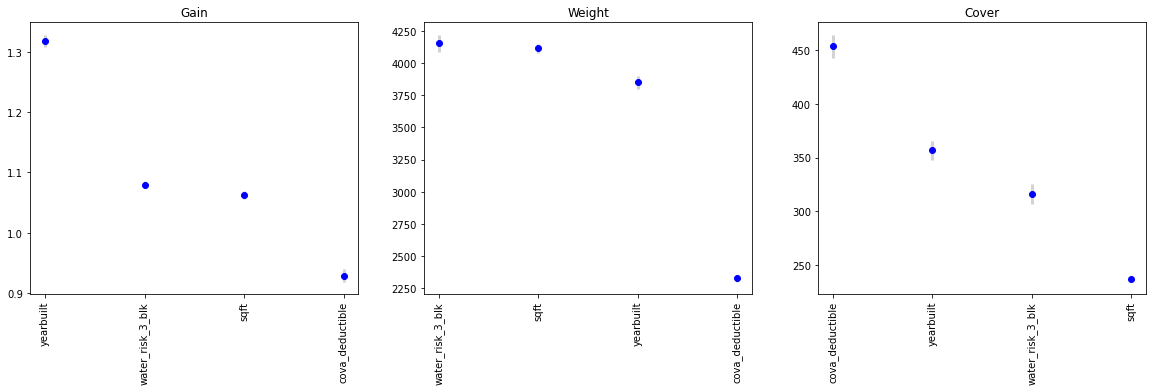

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5)) 

                
ax = axs[0]
ax.errorbar(df_oof_fi_gain_best['feature'], df_oof_fi_gain_best['mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=df_oof_fi_gain_best['sem'], fmt='o')
ax.set_title('Gain')
ax.set_xticklabels(df_oof_fi_gain_best['feature'].values,rotation=90)

ax = axs[1]
ax.errorbar(df_oof_fi_weight_best['feature'], df_oof_fi_weight_best['mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=df_oof_fi_weight_best['sem'], fmt='o')
ax.set_title('Weight')
ax.set_xticklabels(df_oof_fi_weight_best['feature'].values,rotation=90)
                         

ax = axs[2]
ax.errorbar(df_oof_fi_cover_best['feature'], df_oof_fi_cover_best['mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=df_oof_fi_cover_best['sem'], fmt='o')
ax.set_title('Cover')
ax.set_xticklabels(df_oof_fi_cover_best['feature'].values,rotation=90)